In [1]:
# STEP 1: EDA
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
images_dir = os.path.join('./data/train', "images")
img_files = [f for f in os.listdir(images_dir) if f.endswith('.png') or f.endswith('.jpg')]

In [3]:
img_files[:5]

['distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.jpg',
 'distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1.jpg',
 'distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f.jpg',
 'elbow-dislocation-with-coronoid-process-fracture_jpg.rf.234153519323ba2b9aa2e603b0a43771.jpg',
 'elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5.jpg']

In [4]:
# get the labels
label_files = [f for f in os.listdir('./data/train/labels/') if f.endswith('.txt')]
label_files[:5]

['distal-humeral-fractures-2-_JPEG.rf.39ba3f53047ecb4064613850a1c76fc1.txt',
 'distal-humeral-fractures-2-_JPEG.rf.525ce876785d0fd798ec3af1593e5bc1.txt',
 'distal-humeral-fractures-2-_JPEG.rf.f9442db05ec473187c60870d407c9e8f.txt',
 'elbow-dislocation-with-coronoid-process-fracture_jpg.rf.234153519323ba2b9aa2e603b0a43771.txt',
 'elbow-dislocation-with-coronoid-process-fracture_jpg.rf.75b67d2e40fe637ba2838e1283f970c5.txt']

In [5]:
with open(os.path.join('./data/train/labels/', label_files[2]), 'r') as file:
    label = file.read().split()

In [6]:
label = list(map(float, label))

In [7]:
target, x_center, y_center, width, height = label[0:5]
x_min = x_center - width / 2
y_min = y_center - height / 2

print(target)


0.0


In [8]:
from matplotlib.patches import Rectangle
box = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')

In [9]:
image = plt.imread(os.path.join('./data/train/images/', img_files[2]))

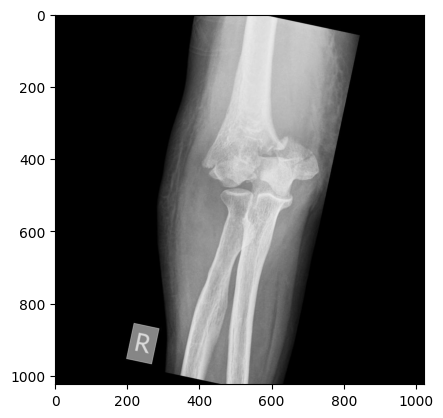

In [10]:
# add the box to the image
plt.imshow(image)
plt.gca().add_patch(box)
plt.show()

In [11]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)


def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


import glob
import random
import os
from torch.utils.data import Dataset
from PIL import Image


class ImageDataset(Dataset):
    def __init__(self, root, transform=None, mode='train'):
        self.transform = transform
        self.files = sorted(glob.glob(os.path.join(root, mode) + '/images/*.jpg'))
        self.labels = {}
        self.boxes = {}
        assert len(self.files) > 0, "Make sure you downloaded the images!"

    def get_image(self, index):
        item = self.transform(Image.open(self.files[index % len(self.files)]))
        if item.shape[0] != 3: 
            item = item.repeat(3, 1, 1)
        # Old versions of PyTorch didn't support normalization for different-channeled images
        return item
    
    def get_labels(self, index):
        if index in self.labels:
            return self.labels[index]
        labels = []
        boxes = []
        text_file = self.files[index % len(self.files)].replace(".jpg", ".txt").replace("images", "labels")
        with open(text_file, mode="r") as f:
            lines = f.readlines()
            for line in lines:
                values = [float(value) for value in line.split()]
                label = int(values[0])
                coords = values[1:]
                coords = torch.reshape(torch.FloatTensor(coords), (int(len(coords)/2), 2))
                size = torch.tensor([self.get_image(index).shape[2], self.get_image(index).shape[1]])
                min_coords = torch.min(coords, dim=0).values * size
                max_coords = torch.max(coords, dim=0).values * size
                box = torch.cat((min_coords, max_coords), dim=0).tolist()
                labels.append(label)
                boxes.append(box)
        self.labels[index] = labels
        self.boxes[index] = torch.ByteTensor(boxes)
        return labels
    
    def get_boxes(self, index):
        if index in self.boxes:
            return self.boxes[index]
        _ = self.get_labels(index)
        return self.boxes[index]

    def __len__(self):
        return len(self.files)

c:\Users\qmirz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
load_shape = 128

transform = transforms.Compose([
    transforms.Resize(load_shape),
    transforms.ToTensor(),
])

import torchvision
dataset = ImageDataset("./data/", transform=transform)

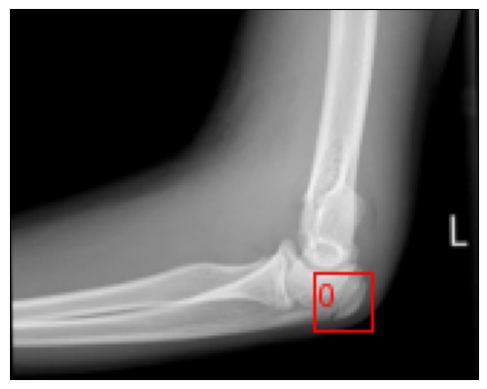

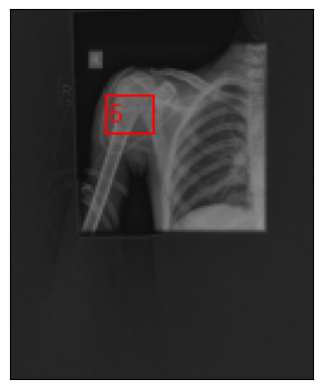

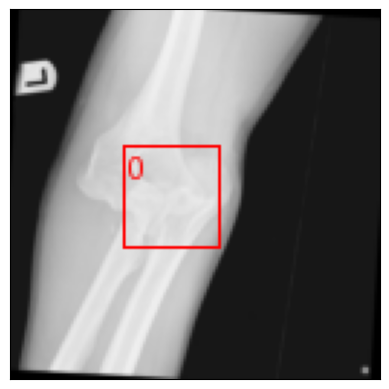

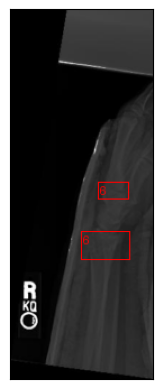

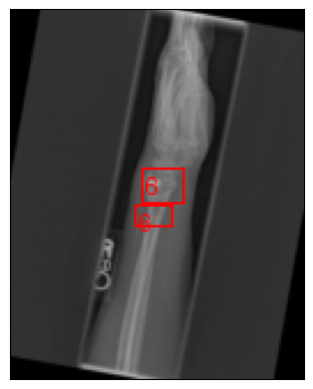

In [13]:
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.functional as F
import numpy as np

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

for index in [8, 1264, 5, 876, 15]:
    img = transforms.functional.convert_image_dtype(dataset.get_image(index), dtype=torch.uint8)
    drawn_boxes = draw_bounding_boxes(img, dataset.get_boxes(index), colors="red", labels=[str(x) for x in dataset.get_labels(index)])
    show(drawn_boxes)

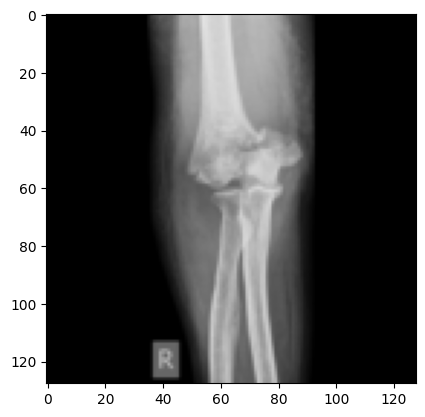

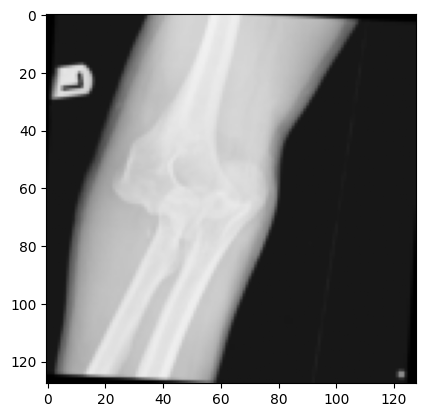

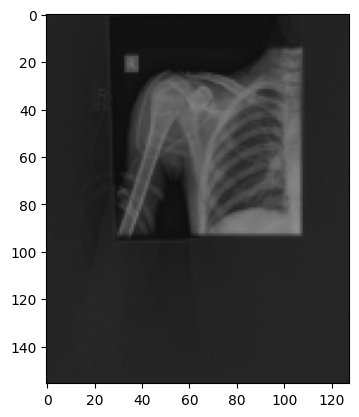

In [14]:
show_tensor_images(dataset.get_image(0), num_images=1, size=(3, 128, 128))
show_tensor_images(dataset.get_image(5), num_images=1, size=(3, 128, 128))
show_tensor_images(dataset.get_image(1264), num_images=1, size=(3, 156, 128))

In [20]:
# THIS IS HOW YOU SOLVE IT WTF

import time

# Retry function
def retry_open_connection():
    max_retries = 3
    retries = 0
    while retries < max_retries:
        try:
            # Open the connection here
            from torchvision.models import resnet50, ResNet50_Weights
            resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
            break
        except Exception as e:
            print(f"Error: {e}")
            print("Retrying...")
            retries += 1
            time.sleep(1)  # Wait for 1 second before retrying

    if retries == max_retries:
        print("Failed to open the connection after multiple retries.")

# Call the retry function
retry_open_connection()


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\qmirz/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


Error: <urlopen error [WinError 10054] An existing connection was forcibly closed by the remote host>
Retrying...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\qmirz/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:05<00:00, 19.3MB/s]
